In [1]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser
from pylab import rcParams
from matplotlib import rc
import matplotlib.pylab as pylab

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=True)
params = {'legend.fontsize': 18,
          'figure.figsize': (6, 4),
          'axes.labelsize': 20,
          'axes.titlesize':20,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'axes.linewidth':1,
        }
pylab.rcParams.update(params)

In [3]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Populations

In [10]:
pspecpop = PowerSpectraPopulations()

In [11]:
pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e4*M_s, M_max=0.04*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_vel = pspecpop.get_C_l_total_ary(n_points=50);

In [7]:
rcParams['figure.figsize'] = 6, 5

alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

## Differential Power

### Over masses

In [12]:
logM_min_plot = 6
logM_max_plot = 11.5

M_ary = np.logspace(logM_min_plot,logM_max_plot,100)*M_s

ell = 10
dlogC_l_dM_ary_10 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])
ell = 30
dlogC_l_dM_ary_30 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])
ell = 100
dlogC_l_dM_ary_100 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])

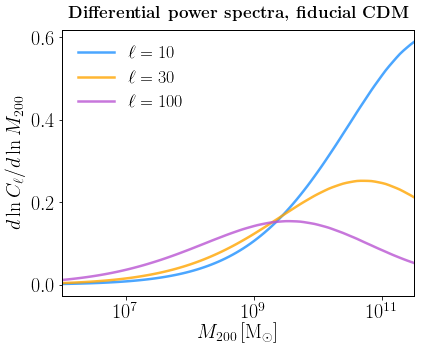

In [13]:
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_10/(1/M_s),label="$\ell = 10$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_30/(1/M_s),label="$\ell = 30$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[1])
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_100/(1/M_s),label="$\ell = 100$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[2])

plt.xlabel("$M_{200}$\,[M$_\odot$]")
plt.ylabel("$d\ln C_\ell/d\ln M_{200}$")

plt.xscale("log")

plt.xlim(10**logM_min_plot, 10**logM_max_plot)

plt.legend(frameon=False)

plt.title('\\textbf{Differential power spectra, fiducial CDM}', y = 1.02, fontsize=17)


plt.tight_layout()
plt.savefig("../../plots/dlnCldlnM200.pdf")

### Over Galactocentric radii

In [14]:
R_min_plot = 1e-2
R_max_plot = 260

R_ary = np.linspace(R_min_plot, R_max_plot, 100)*kpc

ell = 10
dlogC_l_dR_ary_10 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])
ell = 30
dlogC_l_dR_ary_30 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])
ell = 100
dlogC_l_dR_ary_100 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])

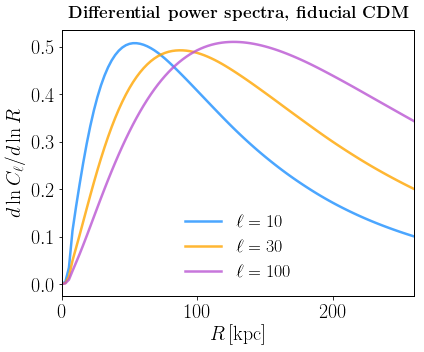

In [15]:
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_10/(1/kpc),label="$\ell = 10$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_30/(1/kpc),label="$\ell = 30$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[1])
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_100/(1/kpc),label="$\ell = 100$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[2])

plt.xlabel("$R$\,[kpc]")
plt.ylabel("$d\ln C_\ell/d\ln R$")

plt.xlim(R_min_plot, R_max_plot)

plt.legend(frameon=False)

plt.title('\\textbf{Differential power spectra, fiducial CDM}', y = 1.02, fontsize=17)

plt.tight_layout()
plt.savefig("../../plots/dlnCldlnR.pdf")

## Total signal and noise power spectrum

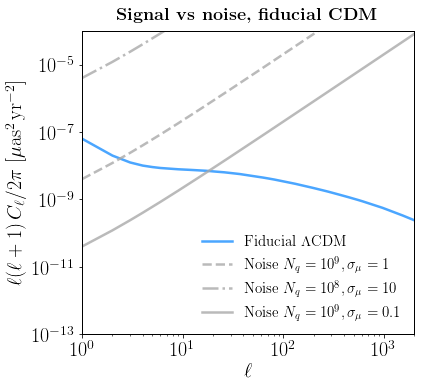

In [12]:
rcParams['figure.figsize'] = 6, 5.5

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*pspecpop.C_l_ary, label="Fiducial $\Lambda$CDM", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])

sigma_mu = 1
sigma_alpha = .1
N_q = 1e9

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = 10
sigma_alpha = .1
N_q = 1e8

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^8, \sigma_\mu=10$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 0.1
sigma_alpha = .1
N_q = 1e9

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^9, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(1, 2000)
plt.ylim(1e-13,1e-4)

plt.legend(frameon=False, ncol=1, fontsize=15, loc='lower right')

plt.title('\\textbf{Signal vs noise, fiducial CDM}', y = 1.02, fontsize=18)

plt.tight_layout()
plt.savefig("../../plots/LCDMTheoryNoise.pdf")

# Fisher Forecasts

In [13]:
sigma_mu = 1
sigma_alpha = .1
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

parameters = [Cl_ary_fid, None, 1, 2000, fDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q=N_q, l_min_mu=5, l_max_mu=300, l_min_alpha=2, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)
lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
print(lim)
baseline_sig = fDM_base/fshr.pars_vary[0].sigma
print(baseline_sig)

28.442923650228813
0.05765933278053878


## LCDM discovery significance

In [18]:
sigma_mu_ary = np.logspace(-2,1,50)
N_q_ary = np.logspace(6,9,50)

In [19]:
sig_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))
lim_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))

for isigmu, sigmu in enumerate(tqdm_notebook(sigma_mu_ary)):
    for iNq, Nq in enumerate(N_q_ary):
        
        fDM_base = 1
        dfDM_base = 0.1

        Cl_ary_fid = pspecpop.C_l_ary*fDM_base

        p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
        m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

        fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                        None, None, '$\\f_\mathrm{DM}$' )

        parameters = [Cl_ary_fid, None, 1, 2000, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigmu, sigma_alpha=None, N_q=Nq, l_min_mu=2, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)
        lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
        sig_ary[isigmu, iNq] = fDM_base/fshr.pars_vary[0].sigma
        lim_ary[isigmu, iNq] = lim


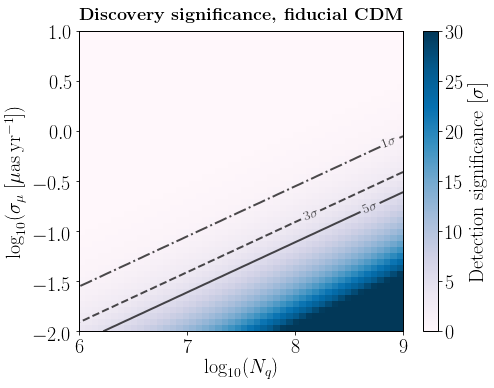

In [20]:
rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
X, Y = np.meshgrid(np.log10(N_q_ary), np.log10(sigma_mu_ary))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sig_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sig_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[6,9,-2,1], vmin=0, vmax=30)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\log_{10}(\sigma_\mu~[\mu$as\,yr$^{-1}$])")
ax.set_title('\\textbf{Discovery significance, fiducial CDM}', y = 1.02, fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
plt.savefig("../../plots/LCDM_disc.pdf")

In [28]:
# l_min_ary = np.linspace(5,30,50)
# l_max_ary = np.linspace(10,100,50)

In [29]:
# sig_l_ary = np.zeros((len(l_max_ary), len(l_min_ary)))

# for ilmax, lmax in enumerate(tqdm_notebook(l_max_ary)):
#     for ilmin, lmin in enumerate((l_min_ary)):
        
#         if lmin >= lmax - 1: continue
            
#         fDM_base = 1
#         dfDM_base = 0.1

#         Cl_ary_fid = pspecpop.C_l_ary*fDM_base

#         p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
#         m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

#         fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
#                         None, None, '$\\f_\mathrm{DM}$' )

#         parameters = [Cl_ary_fid, None, 1, 2000, fDM]
#         observation = AstrometryObservation(fsky=1, sigma_mu=1, sigma_alpha=None, N_q=1e9, l_min_mu=lmin, l_max_mu=lmax, l_min_alpha=10, l_max_alpha=2000)

#         fshr = FisherForecast(parameters, observation)
#         lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
#         sig_l_ary[ilmax, ilmin] = fDM_base/fshr.pars_vary[0].sigma

In [30]:
# rcParams['figure.figsize'] = 7, 5.5

# levels = [0.5,1,1.2]
# X, Y = np.meshgrid(l_min_ary, l_max_ary)

# fig, ax = plt.subplots()

# CS = ax.contour(X, Y, sig_l_ary/baseline_sig, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

# fmt = {}
# strs = ['0.5','1.0','1.2']
# for l, s in zip(CS.levels, strs):
#     fmt[l] = s
    
# im = ax.imshow(sig_l_ary/baseline_sig,cmap = 'PuBu', aspect='auto', origin='lower', extent=[min(l_min_ary), max(l_min_ary), min(l_max_ary),  max(l_max_ary)], vmin=0., vmax=2)

# ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

# ax.set_xlabel("$\ell_\mathrm{min}$")
# ax.set_ylabel("$\ell_\mathrm{max}$")
# ax.set_title('\\textbf{Dependence on $\ell_\mathrm{min}/\ell_\mathrm{max}$, fiducial CDM}', y = 1.02, fontsize=18)

# cbar = fig.colorbar(im)
# cbar.set_label('$\sigma$/$\sigma_\mathrm{baseline}$')

# plt.tight_layout()
# plt.savefig("../Plots/LCDM_lminmax.pdf")
